In [150]:
# Importing all required packages
import numpy as np
import pandas as pd
from datetime import datetime as dt

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [151]:
#reading Dataset
cricket = pd.read_csv("Cricket.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [152]:
cricket.dtypes

Player     object
Span       object
Mat         int64
Inns        int64
NO          int64
Runs        int64
HS         object
Ave       float64
BF          int64
SR        float64
100         int64
50          int64
0           int64
dtype: object

In [153]:
cricket.describe().T

,count,mean,std,min,25%,50%,75%,max
Mat,79.0,245.075949,74.211716,128.00,188.000,232.00,281.500,463.00
Inns,79.0,230.544304,70.321022,127.00,177.000,217.00,261.500,452.00
NO,79.0,30.037975,14.421710,4.00,17.500,29.00,40.000,70.00
Runs,79.0,7618.139241,2551.873313,5080.00,5759.000,6798.00,8739.500,18426.00
Ave,79.0,38.523291,5.919093,23.57,34.600,37.87,41.845,53.94
BF,79.0,9684.455696,3193.835825,5504.00,7393.500,9134.00,10976.000,21367.00
SR,79.0,79.295316,9.925307,60.57,73.725,77.73,85.180,117.00
100,79.0,11.556962,8.092014,0.00,6.000,10.00,15.500,49.00
50,79.0,46.443038,16.351701,23.00,34.500,42.00,54.000,96.00
0,79.0,13.253165,5.925755,3.00,9.000,13.00,16.000,34.00


In [154]:
cricket.shape

(79, 13)

In [155]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(cricket.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(cricket.isnull().sum()/cricket.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1)

,Total,Percentage
0,0,0.0
50,0,0.0
100,0,0.0
SR,0,0.0
BF,0,0.0
Ave,0,0.0
HS,0,0.0
Runs,0,0.0
NO,0,0.0
Inns,0,0.0


In [156]:
cricket_slice = cricket[['Player','Ave','SR']]
cricket_slice.head()

,Player,Ave,SR
0,SR Tendulkar (INDIA),44.83,86.23
1,KC Sangakkara (Asia/ICC/SL),41.98,78.86
2,RT Ponting (AUS/ICC),42.03,80.39
3,ST Jayasuriya (Asia/SL),32.36,91.20
4,DPMD Jayawardene (Asia/SL),33.37,78.96


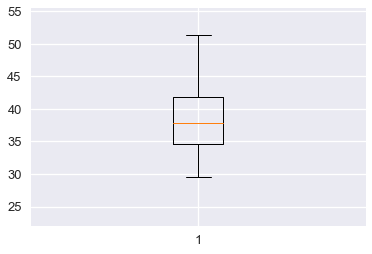

In [157]:
plt.boxplot(cricket_slice.Ave)
plt.show()

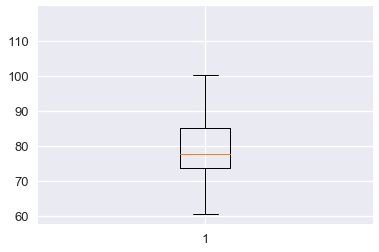

In [158]:
plt.boxplot(cricket_slice.SR)
plt.show()

### Scaling the RFM data

In [159]:
# Standardize all parameters
cricket_norm1 = cricket_slice.drop("Player", axis =1)
cricket_norm1.head()

,Ave,SR
0,44.83,86.23
1,41.98,78.86
2,42.03,80.39
3,32.36,91.20
4,33.37,78.96


In [160]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

num_vars = ['Ave', 'SR']

cricket_norm1[num_vars] = Scaler.fit_transform(cricket_norm1[num_vars])
cricket_norm1.head()

,Ave,SR
0,1.072294,0.703152
1,0.587725,-0.044139
2,0.596226,0.110997
3,-1.047909,1.207091
4,-0.876185,-0.034000


In [161]:
cricket_norm1.describe().T

,count,mean,std,min,25%,50%,75%,max
Ave,79.0,4.497106e-17,1.00639,-2.542423,-0.667055,-0.111075,0.564771,2.621216
SR,79.0,7.908582e-16,1.00639,-1.898679,-0.564810,-0.158717,0.596685,3.823117


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [162]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [163]:
hopkins(cricket_norm1)

0.7061524179891353

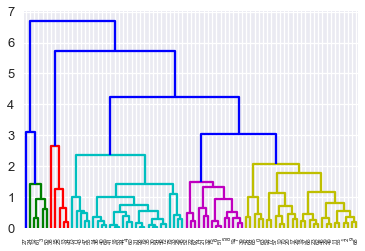

In [164]:
# with complete linkage
mergings = linkage(cricket_norm1, method = "complete", metric = "euclidean")
dendrogram(mergings, color_threshold = 3)
plt.show()

In [165]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
cricket_hc = pd.concat([cricket_slice, clusterCut], axis=1)
cricket_hc.columns = ['Player', 'Batting Avg', 'SR','ClusterID']
cricket_hc.head()

,Player,Batting Avg,SR,ClusterID
0,SR Tendulkar (INDIA),44.83,86.23,0
1,KC Sangakkara (Asia/ICC/SL),41.98,78.86,0
2,RT Ponting (AUS/ICC),42.03,80.39,0
3,ST Jayasuriya (Asia/SL),32.36,91.20,1
4,DPMD Jayawardene (Asia/SL),33.37,78.96,2


In [166]:
#exporting into csv
cricket_hc.to_csv("batsman_clusters_7_hc.csv", sep=',')

In [167]:
#summarise
hc_clusters_bat_avg = pd.DataFrame(cricket_hc.groupby(["ClusterID"])['Batting Avg'].mean())
hc_clusters_sr = pd.DataFrame(cricket_hc.groupby(["ClusterID"])['SR'].mean())

In [168]:
df = pd.concat([pd.Series([0,1,2,3,4]), hc_clusters_bat_avg, hc_clusters_sr], axis=1)
df.columns = ["ClusterID", "Bat_Avg_Mean", "SR_Mean"]
df

,ClusterID,Bat_Avg_Mean,SR_Mean
0,0,41.066829,78.366829
1,1,33.834000,96.520000
2,2,33.489630,74.390741
3,3,52.528000,88.628000
4,4,23.570000,117.000000


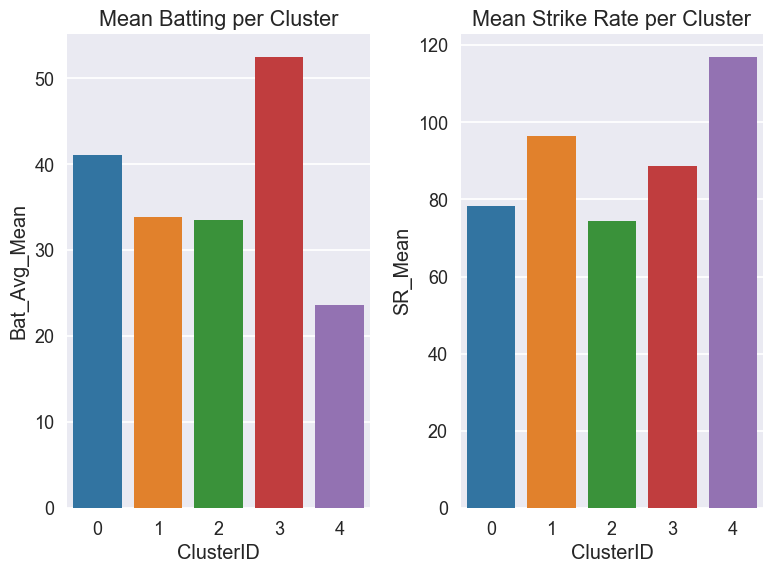

In [149]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/darkgrid/ticks
sns.set_context("talk") # talk/poster/paper

# subplot 1
plt.subplot(1, 2, 1)
sns.barplot(x=df.ClusterID, y=df.Bat_Avg_Mean)
# plot title
plt.title("Mean Batting per Cluster")

# subplot 2
plt.subplot(1, 2, 2)
sns.barplot(x=df.ClusterID, y=df.SR_Mean)
# plot title
plt.title("Mean Strike Rate per Cluster")

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()


In [170]:
clusterCut1 = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
cricket_hc1 = pd.concat([cricket_norm1, clusterCut], axis=1)
cricket_hc1.columns = ['Batting Avg', 'SR','ClusterID']
cricket_hc1.head()

,Batting Avg,SR,ClusterID
0,1.072294,0.703152,0
1,0.587725,-0.044139,0
2,0.596226,0.110997,0
3,-1.047909,1.207091,1
4,-0.876185,-0.034000,2


In [171]:
#summarise
hc_clusters_bat_avg1 = pd.DataFrame(cricket_hc1.groupby(["ClusterID"])['Batting Avg'].mean())
hc_clusters_sr1 = pd.DataFrame(cricket_hc1.groupby(["ClusterID"])['SR'].mean())

In [185]:
df = pd.concat([pd.Series([0,1,2,3,4]), hc_clusters_bat_avg1, hc_clusters_sr1], axis=1)
df.columns = ["ClusterID", "Bat_Avg_Mean", "SR_Mean"]
df

,ClusterID,Bat_Avg_Mean,SR_Mean
0,0,0.432463,-0.094145
1,1,-0.797294,1.746520
2,2,-0.855845,-0.497306
3,3,2.381141,0.946300
4,4,-2.542423,3.823117


In [186]:
X = np.array([[0.432463, -0.094145],
              [-0.797294, 1.746520],
              [-0.855845,-0.497306],
              [2.381141,0.946300],
              [-2.542423,3.823117]], np.float64)
model_clus5 = KMeans(n_clusters=5,init=X,n_init=1,random_state=100)
model_clus5.fit(cricket_norm1)


KMeans(algorithm='auto', copy_x=True,
    init=array([[ 0.43246, -0.09415],
       [-0.79729,  1.74652],
       [-0.85584, -0.49731],
       [ 2.38114,  0.9463 ],
       [-2.54242,  3.82312]]),
    max_iter=300, n_clusters=5, n_init=1, n_jobs=1,
    precompute_distances='auto', random_state=100, tol=0.0001, verbose=0)

In [194]:
centers = model_clus5.cluster_centers_
print(centers)

[[ 0.51526809 -0.39633578]
 [-0.2292423   1.15313399]
 [-0.79003921 -0.56666863]
 [ 2.0070027   0.91722455]
 [-2.5424233   3.82311689]]


In [182]:
X.shape[0] == 5

True

In [183]:
X.shape[1] == cricket_norm1.shape[1]

True

In [184]:
X.shape

(5, 2)

In [195]:
# analysis of clusters formed
cricket_slice.index = pd.RangeIndex(len(cricket_slice.index))
cricket_km = pd.concat([cricket_slice, pd.Series(model_clus5.labels_)], axis=1)
cricket_km.columns = ['Player', 'Batting Avg', 'SR','ClusterID']
cricket_km.head()

,Player,Batting Avg,SR,ClusterID
0,SR Tendulkar (INDIA),44.83,86.23,3
1,KC Sangakkara (Asia/ICC/SL),41.98,78.86,0
2,RT Ponting (AUS/ICC),42.03,80.39,0
3,ST Jayasuriya (Asia/SL),32.36,91.20,1
4,DPMD Jayawardene (Asia/SL),33.37,78.96,2


In [196]:
#exporting into csv
cricket_km.to_csv("batsman_clusters_hrc_km.csv", sep=',')

In [198]:
km_clusters_avg = pd.DataFrame(cricket_km.groupby(["ClusterID"])['Batting Avg'].mean())
km_clusters_sr = pd.DataFrame(cricket_km.groupby(["ClusterID"])['SR'].mean())

In [199]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_avg, km_clusters_sr], axis=1)
df.columns = ["ClusterID", "Batting_avg_mean", "SR_mean"]
df

,ClusterID,Batting_avg_mean,SR_mean
0,0,41.553846,75.386538
1,1,37.175000,90.667857
2,2,33.876667,73.706667
3,3,50.327500,88.341250
4,4,23.570000,117.000000


In [201]:
master_batsman=pd.merge(cricket_km,df, how='inner', on='ClusterID')
master_batsman.head()

,Player,Batting Avg,SR,ClusterID,Batting_avg_mean,SR_mean
0,SR Tendulkar (INDIA),44.83,86.23,3,50.3275,88.34125
1,MS Dhoni (Asia/INDIA),51.32,88.69,3,50.3275,88.34125
2,AB de Villiers (Afr/SA),53.55,100.25,3,50.3275,88.34125
3,V Kohli (INDIA),53.94,90.99,3,50.3275,88.34125
4,HM Amla (SA),50.25,89.05,3,50.3275,88.34125


In [206]:
master_batsman.columns=['Player', 'Batting Avg', 'SR', 'ClusterID', 'Batting Avg Cluster Mean','SR Cluster Mean']
master_batsman.head()

,Player,Batting Avg,SR,ClusterID,Batting Avg Cluster Mean,SR Cluster Mean
0,SR Tendulkar (INDIA),44.83,86.23,3,50.3275,88.34125
1,MS Dhoni (Asia/INDIA),51.32,88.69,3,50.3275,88.34125
2,AB de Villiers (Afr/SA),53.55,100.25,3,50.3275,88.34125
3,V Kohli (INDIA),53.94,90.99,3,50.3275,88.34125
4,HM Amla (SA),50.25,89.05,3,50.3275,88.34125


In [207]:
#exporting into csv
master_batsman.to_csv("batsman_clusters_hrc_km.csv", sep=',')

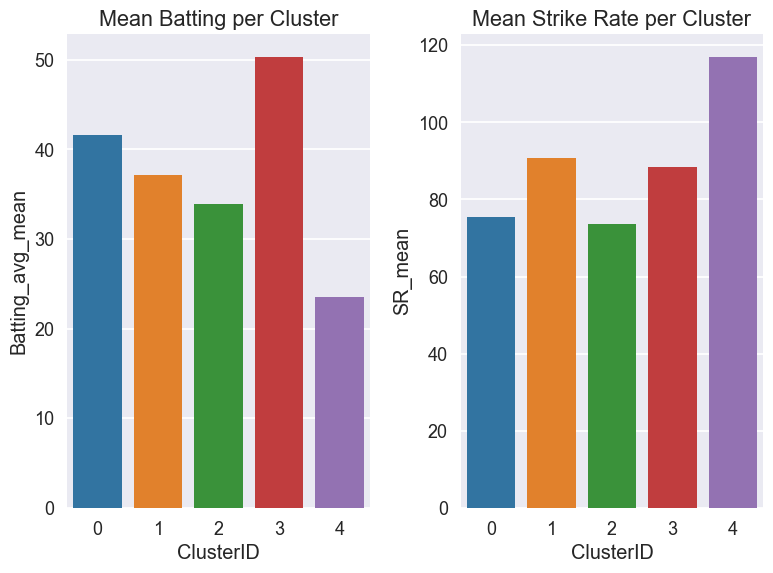

In [200]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/darkgrid/ticks
sns.set_context("talk") # talk/poster/paper

# subplot 1
plt.subplot(1, 2, 1)
sns.barplot(x=df.ClusterID, y=df.Batting_avg_mean)
# plot title
plt.title("Mean Batting per Cluster")

# subplot 2
plt.subplot(1, 2, 2)
sns.barplot(x=df.ClusterID, y=df.SR_mean)
# plot title
plt.title("Mean Strike Rate per Cluster")

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()
